# Benchmark for Community detection

In [1]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import extract_labels_from_communities, time_tester, calculate_scores_CD

from LocalStable import locally_stable_clustering_with_hop_distance

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_node_labels

from PlotHelperFunctions import plot_clustering, plot_stuff

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity


import data.jazz as jazz
import data.cora as cora

## Create Graphs

In [2]:
repetitions = 1    #Number of random isomorph permutation for each graph

cora_graph = cora.get_graph()

cora_graph = nx.relabel_nodes(cora_graph, {list(cora_graph.nodes())[i] : i for i in range(len(cora_graph.nodes()))} )
cora_truth = list(cora_graph.nodes[i]['subject'] for i in range(len(cora_graph.nodes())))
cora_perm_graph = []
cora_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(cora_graph,cora_truth)
    cora_perm_graph += [g]
    cora_perm_truth += [t]


jazz_graph = jazz.get_graph()
jazz_graph = nx.relabel_nodes(jazz_graph, {i : i-1 for i in range(len(jazz_graph)+1)} )
jazz_graph,_ = randomize_graph_node_labels(jazz_graph,None)
jazz_truth = None

jazz_perm_graph = []
jazz_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(jazz_graph,jazz_truth)
    jazz_perm_graph += [g]
    jazz_perm_truth += [t]


karate_graph = nx.karate_club_graph()
#karate_graph,_ = randomize_graph_node_labels(karate_graph,None)
karate_truth = list(karate_graph.nodes[i]["club"] for i in range(34))

karate_perm_graph = []
karate_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(karate_graph,karate_truth)
    karate_perm_graph += [g]
    karate_perm_truth += [t]

karate_perm_graph = [karate_graph,karate_graph,karate_graph,karate_graph,karate_graph]
karate_perm_truth = [karate_truth,karate_truth,karate_truth,karate_truth,karate_truth]

graph,graph_truth = generate_graph(10,25,0.2,0.05)

graph_perm_graph = []
graph_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(graph,graph_truth)
    graph_perm_graph += [g]
    graph_perm_truth += [t]




## Run the algorithms


In [3]:
import itertools
import timeit

f = 0.2   #f-bound
e = 0.2   #e-bound


graphs = [karate_perm_graph,cora_perm_graph,jazz_perm_graph,graph_perm_graph]
expected_clusters = [2,7,None,25]
graph_names = [ 'Karate Club','Cora','Jazz','25 random communities']
graph_truths =  [karate_perm_truth,cora_perm_truth,jazz_perm_truth,graph_perm_truth]


𝓗 = Modularity(1.0)

fn_louvain_mod = lambda G,_: louvain(G, 𝓗)
fn_leiden_mod  = lambda G,_: leiden(G, 𝓗)

louv_out = None
lei_out = None

algorithms = [ fn_louvain_mod, fn_leiden_mod]
algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)']

lp_a_b =lambda agents, initial_clustering, pre: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='B',pre = pre)
lp_a_f =lambda agents, initial_clustering, pre: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='F',pre = pre)
lp_a_e =lambda agents, initial_clustering, pre: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='E',pre = pre)

algorithms = [ fn_louvain_mod, fn_leiden_mod,lp_a_b,lp_a_f,lp_a_e]
algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)','LP (Balanced) Heuristic',\
               'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
is_lp_heuristic = [False,False,True, True, True]

collected_data = {}
for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
    itertools.product(zip(graphs, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
    
        
        
    agents = []
    for i in range(len(graph)):
        agents += [list(graph[i].nodes())]


    if lp_heuristic:
        # start with everyone alone
        a_name_modified = a_name + ' starting with everyone alone'
        initial_clusters = len(agents[0])
        if graph == cora_perm_graph:
            a_name_modified += ' *6 starting clusters'
            initial_clusters = 6
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        
        test_callable = lambda a: algo(a,initial_clusters,None)
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        
        # starting with predicted number of clusters
        a_name_modified = a_name + ' starting with predicted number of clusters'
        initial_clusters = clusters
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        
        test_callable = lambda a: algo(a,initial_clusters,None)
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        
        # start with the output of leiden
        a_name_modified = a_name + ' starting with the output of leiden'
        initial_clusters = clusters
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        
        test_callable = lambda a: algo(a,initial_clusters,fn_leiden_mod)
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)

        rand_score_with_init = sum(rand_score(list(out.values()), list(lei.values())) for out, lei in zip(outputs, lei_output)) / len(outputs)
        scores['Rand Score with initial clustering'] = rand_score_with_init
        
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

       

    else:
        print(f"Running {a_name} on {g_name} … ", end='')
        test_callable = lambda a : algo(a,_)
        times,outputs = time_tester(test_callable,graph)
        outputs = [extract_labels_from_communities(c.communities) for c in outputs]

        if algo == fn_leiden_mod:
            lei_output = outputs
            
        
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)
        scores['Time'] = avg_time
        collected_data[(a_name,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))


Running Louvain (Mod) on Karate Club … execution time: ~ 0.005122 seconds.
Rand Index : ~ 0.6470588235294118
Modularity : ~ 0.4362643128876895
Time : ~ 0.005121720000170171
Running Leiden (Mod) on Karate Club … execution time: ~ 0.011148 seconds.
Rand Index : ~ 0.6556149732620321
Modularity : ~ 0.4334907516725699
Time : ~ 0.011148199997842312
Running LP (Balanced) Heuristic starting with everyone alone on Karate Club … execution time: ~ 0.016674 seconds.
Rand Index : ~ 0.5525846702317291
Modularity : ~ 0.2066115702479338
Time : ~ 0.016673920012544842
Running LP (Balanced) Heuristic starting with predicted number of clusters on Karate Club … execution time: ~ 0.001498 seconds.
Rand Index : ~ 0.5294117647058824
Modularity : ~ 0.2790708569929349
Time : ~ 0.0014980200096033514
Running LP (Balanced) Heuristic starting with the output of leiden on Karate Club … execution time: ~ 0.014855 seconds.
Rand Index : ~ 0.699108734402852
Modularity : ~ 0.4284421206499128
Rand Score with initial clust

KeyboardInterrupt: 

## Gather the numbers

We can use the collected_data dictionairy to build a table for better comparison


In [83]:
print(collected_data)

{('Louvain (Mod)', 'Karate Club'): {'Rand Index': 0.6598930481283423, 'Modularity': 0.43413541725230037, 'Time': 0.010711660000379198}, ('Leiden (Mod)', 'Karate Club'): {'Rand Index': 0.6752228163992869, 'Modularity': 0.4417158598976781, 'Time': 0.02348840000049677}, ('LP (Balanced) Heuristic starting with everyone alone', 'Karate Club'): {'Rand Index': 0.5525846702317291, 'Modularity': 0.20661157024793392, 'Time': 0.013931239998782985}, ('LP (Balanced) Heuristic starting with predicted number of clusters', 'Karate Club'): {'Rand Index': 0.5294117647058824, 'Modularity': 0.2790708569929349, 'Time': 0.002882459998363629}, ('LP (Balanced) Heuristic starting with the output of leiden', 'Karate Club'): {'Rand Index': 0.704812834224599, 'Modularity': 0.4293866306853319, 'Rand Score with initial clustering': 0.693048128342246, 'Time': 0.02649857999786036}, ('LP (Friend-Oriented) Heuristic starting with everyone alone', 'Karate Club'): {'Rand Index': 0.5597147950089126, 'Modularity': 0.260077

In [84]:
import pandas as pd
records = []
for (method, dataset), metrics in collected_data.items():
    record = {'Method': method, 'Dataset': dataset}
    record.update(metrics)
    records.append(record)

df = pd.DataFrame(records)

def sort_within_datasets(df, score_column, ascending=False):
    """
    Sort the rows within each dataset group by the given score column.

    Parameters:
    - df: pandas DataFrame containing 'Dataset' and score columns.
    - score_column: str, the column to sort by (e.g., 'Rand Index').
    - ascending: bool, whether to sort in ascending order (default: descending).

    Returns:
    - A sorted DataFrame.
    """
    return df.sort_values(by=['Dataset', score_column], ascending=[True, ascending])

# Example usage:
sorted_df = sort_within_datasets(df, 'Rand Index', ascending=False)

sorted_df

,Method,Dataset,Rand Index,Modularity,Time,Rand Score with initial clustering
41,LP (Enemy-Averse) Heuristic starting with ever...,25 random communities,0.958137,0.093949,3.152740,NaN
35,LP (Balanced) Heuristic starting with everyone...,25 random communities,0.956787,0.105519,3.505257,NaN
38,LP (Friend-Oriented) Heuristic starting with e...,25 random communities,0.955373,0.123181,4.175357,NaN
39,LP (Friend-Oriented) Heuristic starting with p...,25 random communities,0.93057,0.177050,0.590005,NaN
36,LP (Balanced) Heuristic starting with predicte...,25 random communities,0.930538,0.175008,0.571986,NaN
42,LP (Enemy-Averse) Heuristic starting with pred...,25 random communities,0.930538,0.175008,0.538813,NaN
33,Louvain (Mod),25 random communities,0.862265,0.225913,0.532090,NaN
34,Leiden (Mod),25 random communities,0.853108,0.234521,0.721373,NaN
43,LP (Enemy-Averse) Heuristic starting with the ...,25 random communities,0.85192,0.236021,0.937362,0.786378
37,LP (Balanced) Heuristic starting with the outp...,25 random communities,0.851277,0.241158,0.929391,0.786313


In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_score_by_method(df_all, dataset_name, score_col='Rand Index', save_path=None):
    df = df_all[df_all['Dataset'] == dataset_name].copy()

    # Label method group
    def method_group(row):
        if 'everyone alone *6' in row['Method']:
            return 'LP - alone*6'
        elif 'everyone alone' in row['Method']:
            return 'LP - alone'
        elif 'predicted number of clusters' in row['Method']:
            return 'LP - pred. clusters'
        elif 'leiden' in row['Method']:
            return 'LP - from Leiden'
        elif 'Louvain' in row['Method']:
            return 'Louvain'
        elif 'Leiden' in row['Method']:
            return 'Leiden'
        else:
            return 'Other'

    def variant_label(row):
        if 'Friend-Oriented' in row['Method']:
            return 'Friend-Oriented'
        elif 'Balanced' in row['Method']:
            return 'Balanced'
        elif 'Enemy-Averse' in row['Method']:
            return 'Enemy-Averse'
        else:
            return 'None'

    df['method_group'] = df.apply(method_group, axis=1)
    df['variant'] = df.apply(variant_label, axis=1)

    # Split df
    one_point_methods = ['Louvain', 'Leiden']
    df_single = df[df['method_group'].isin(one_point_methods)]
    df_lp = df[~df['method_group'].isin(one_point_methods)]

    plt.figure(figsize=(10, 6))

    # First plot single point methods
    sns.stripplot(
        data=df_single, x='method_group', y=score_col,
        color='gray', size=8, jitter=False
    )

    # Then overlay LP methods with hue
    sns.stripplot(
        data=df_lp, x='method_group', y=score_col, hue='variant',
        dodge=True, size=8, palette='Set2', alpha=0.9
    )

    plt.title(f'{score_col} for Methods on {dataset_name}')
    plt.xlabel('Method')
    plt.ylabel(score_col)
    plt.ylim(0,1)
    plt.xticks(rotation=30)
    plt.legend(title='LP Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
        print(f"Figure saved as {save_path}")
    plt.show()


In [86]:
import pandas as pd
records = []
for (method, dataset), metrics in collected_data.items():
    record = {'Method': method, 'Dataset': dataset}
    record.update(metrics)
    records.append(record)

df = pd.DataFrame(records)

def sort_within_datasets(df, score_column, ascending=False):
    """
    Sort the rows within each dataset group by the given score column.

    Parameters:
    - df: pandas DataFrame containing 'Dataset' and score columns.
    - score_column: str, the column to sort by (e.g., 'Rand Index').
    - ascending: bool, whether to sort in ascending order (default: descending).

    Returns:
    - A sorted DataFrame.
    """
    return df.sort_values(by=['Dataset', score_column], ascending=[True, ascending])

# Example usage:
sorted_df = sort_within_datasets(df, 'Rand Index', ascending=False)

sorted_df

,Method,Dataset,Rand Index,Modularity,Time,Rand Score with initial clustering
41,LP (Enemy-Averse) Heuristic starting with ever...,25 random communities,0.958137,0.093949,3.152740,NaN
35,LP (Balanced) Heuristic starting with everyone...,25 random communities,0.956787,0.105519,3.505257,NaN
38,LP (Friend-Oriented) Heuristic starting with e...,25 random communities,0.955373,0.123181,4.175357,NaN
39,LP (Friend-Oriented) Heuristic starting with p...,25 random communities,0.93057,0.177050,0.590005,NaN
36,LP (Balanced) Heuristic starting with predicte...,25 random communities,0.930538,0.175008,0.571986,NaN
42,LP (Enemy-Averse) Heuristic starting with pred...,25 random communities,0.930538,0.175008,0.538813,NaN
33,Louvain (Mod),25 random communities,0.862265,0.225913,0.532090,NaN
34,Leiden (Mod),25 random communities,0.853108,0.234521,0.721373,NaN
43,LP (Enemy-Averse) Heuristic starting with the ...,25 random communities,0.85192,0.236021,0.937362,0.786378
37,LP (Balanced) Heuristic starting with the outp...,25 random communities,0.851277,0.241158,0.929391,0.786313


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/25 random communities-Rand Index.png


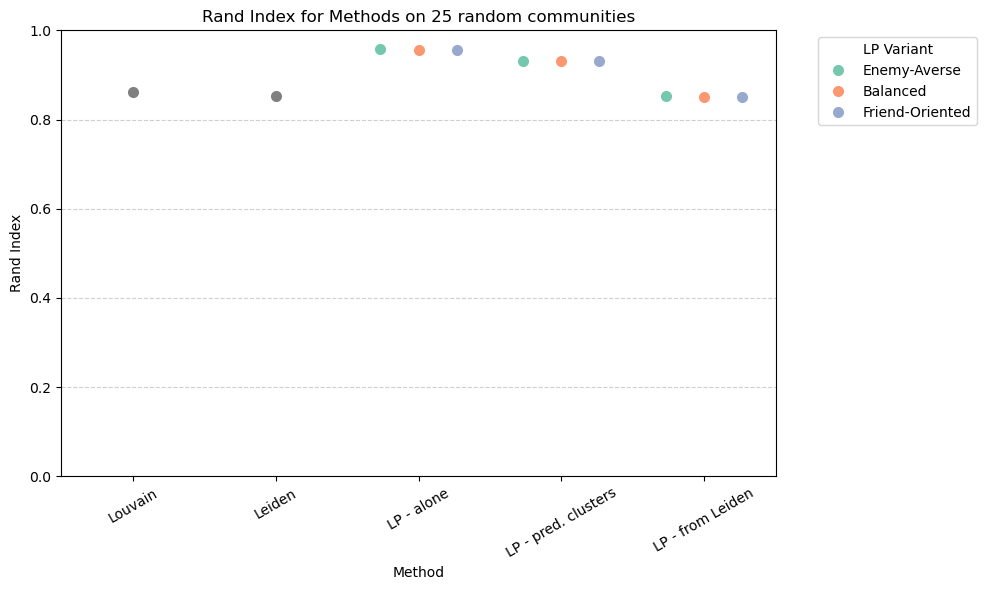

Figure saved as /Users/User/Downloads/local-popular-main-final/0202/25 random communities-Modularity.png


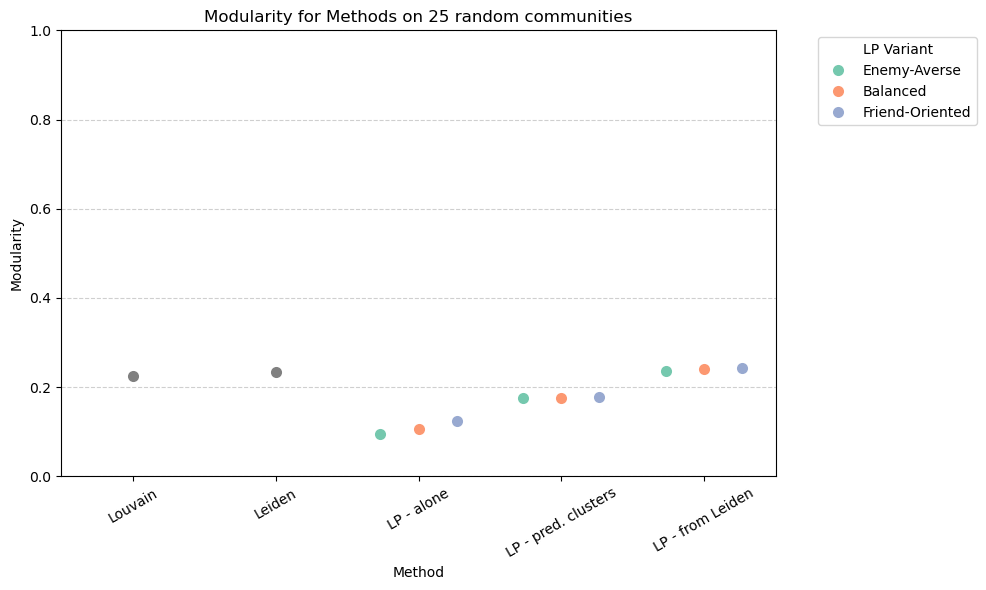

Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Cora-Rand Index.png


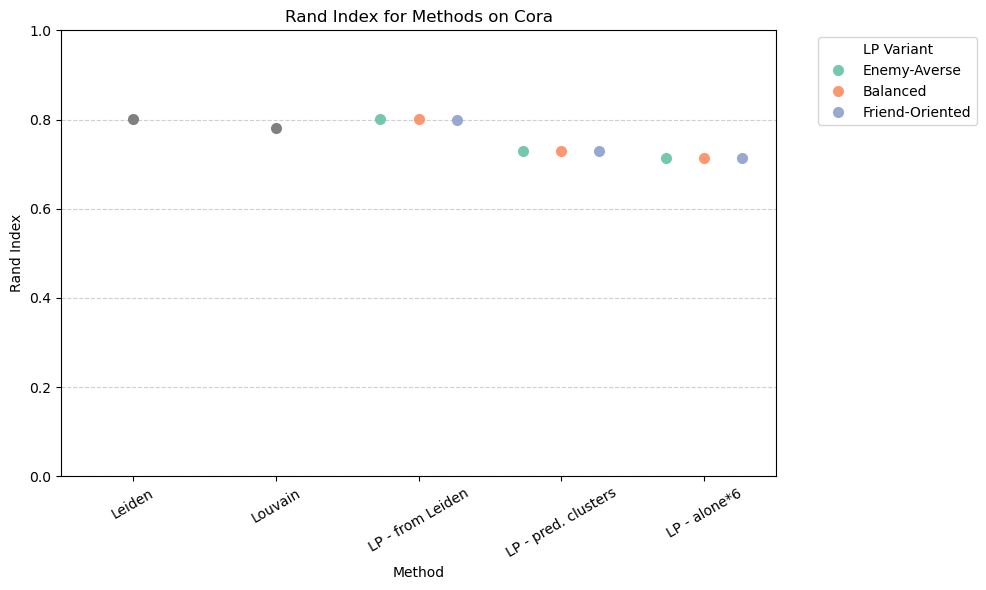

Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Cora-Modularity.png


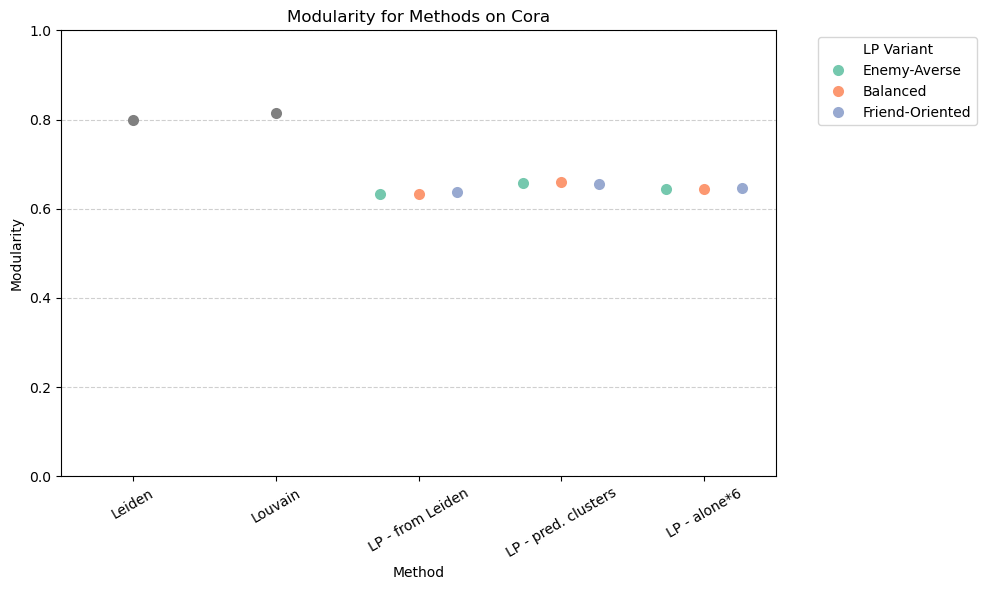

Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Jazz-Rand Index.png


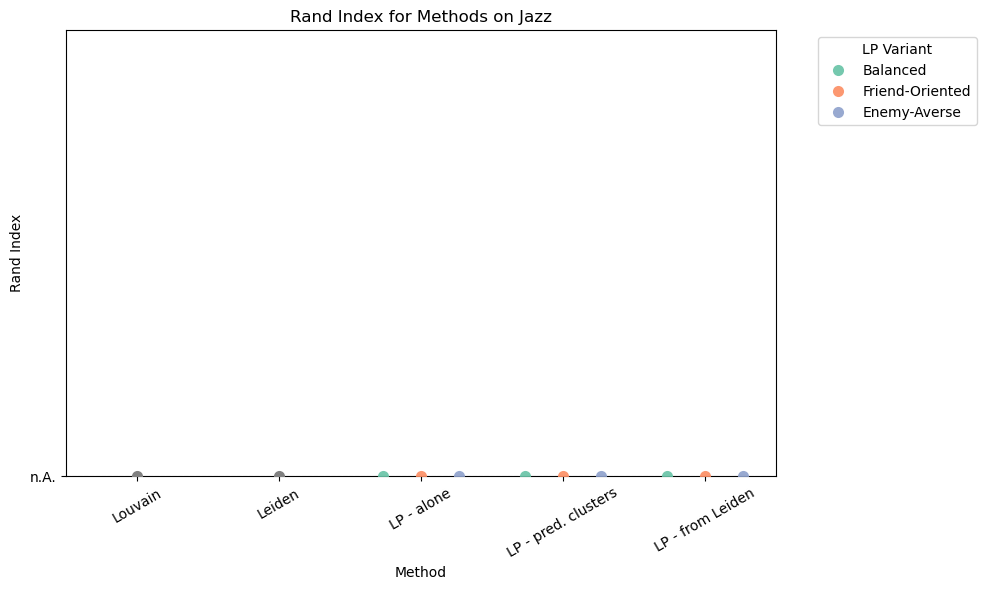

Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Jazz-Modularity.png


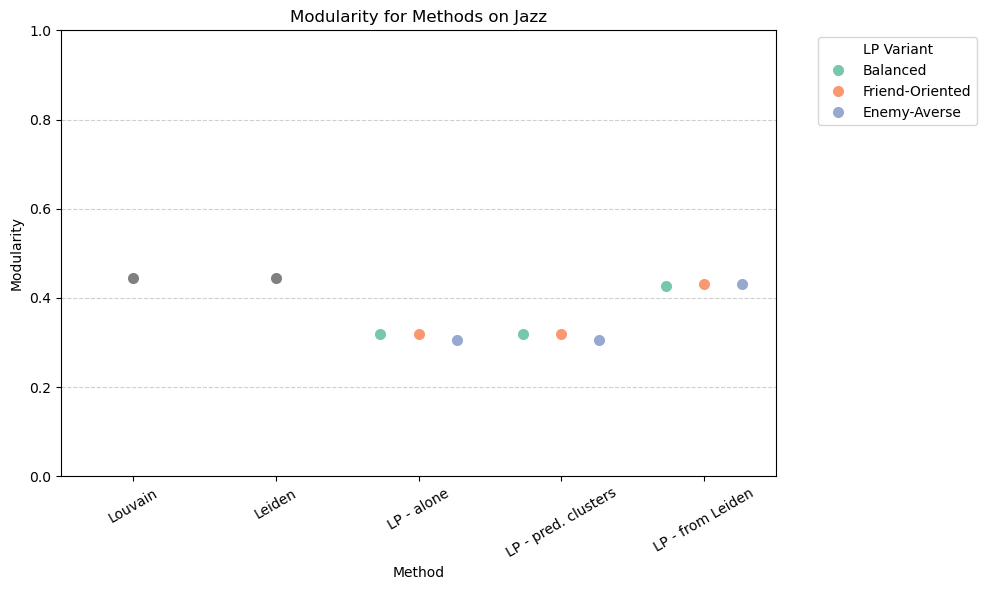

Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Karate Club-Rand Index.png


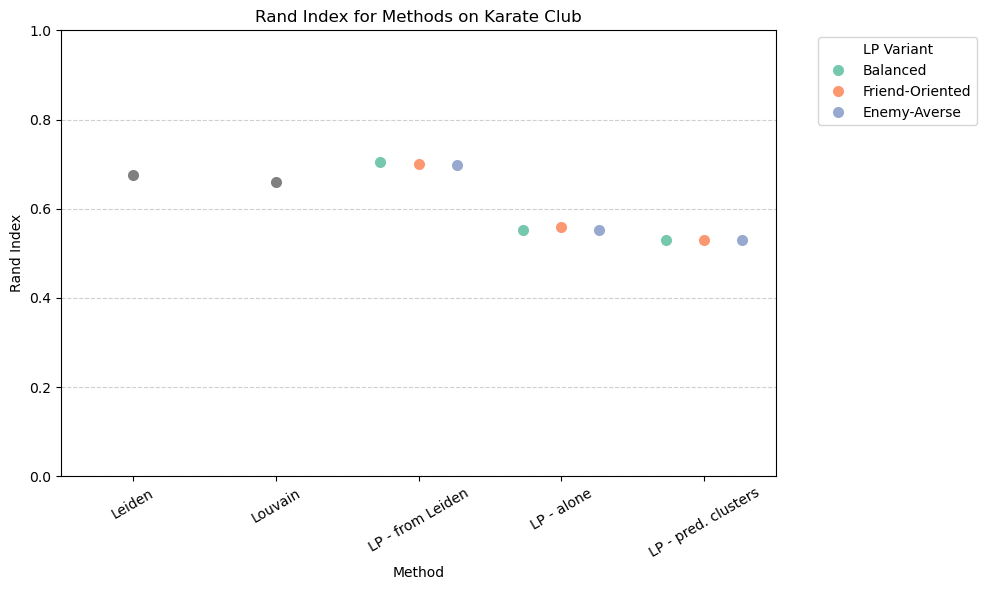

Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Karate Club-Modularity.png


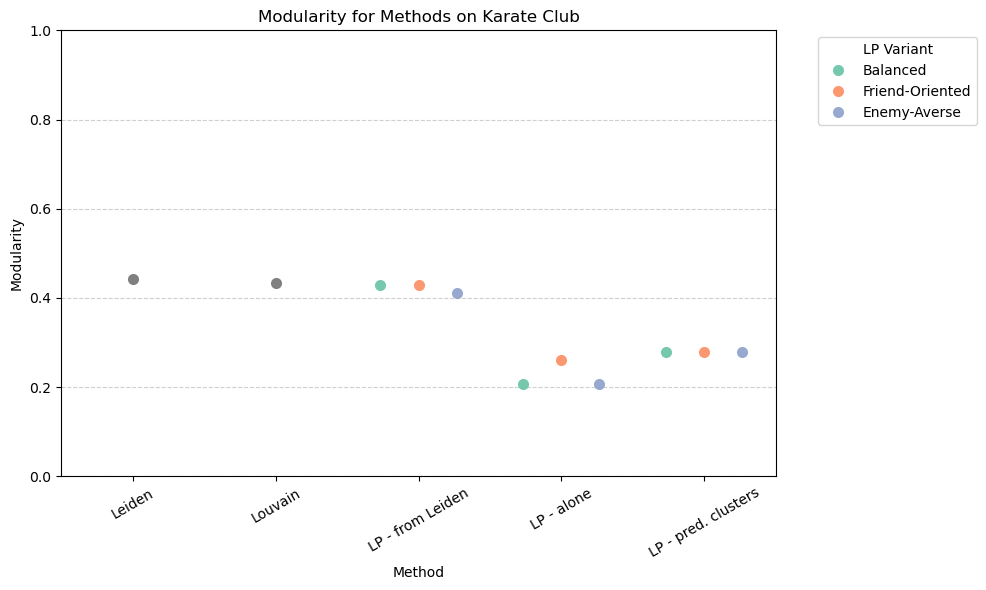

In [87]:
for Dataset in ['25 random communities', 'Cora' ,'Jazz' ,'Karate Club']:
    for score in ['Rand Index', 'Modularity']:
        plot_score_by_method(sorted_df, Dataset, score_col = score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


In [88]:
import itertools
import timeit

f = 0.2   #f-bound
e = 0.3   #e-bound


graphs = [karate_perm_graph,cora_perm_graph,jazz_perm_graph,graph_perm_graph]
expected_clusters = [2,7,None,25]
graph_names = [ 'Karate Club','Cora','Jazz','25 random communities']
graph_truths =  [karate_perm_truth,cora_perm_truth,jazz_perm_truth,graph_perm_truth]


𝓗 = Modularity(1.0)

fn_louvain_mod = lambda G,_: louvain(G, 𝓗)
fn_leiden_mod  = lambda G,_: leiden(G, 𝓗)

louv_out = None
lei_out = None

algorithms = [ fn_louvain_mod, fn_leiden_mod]
algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)']

lp_a_b =lambda agents, initial_clustering, pre: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='B',pre = pre)
lp_a_f =lambda agents, initial_clustering, pre: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='F',pre = pre)
lp_a_e =lambda agents, initial_clustering, pre: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='E',pre = pre)

algorithms = [ fn_louvain_mod, fn_leiden_mod,lp_a_b,lp_a_f,lp_a_e]
algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)','LP (Balanced) Heuristic',\
               'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
is_lp_heuristic = [False,False,True, True, True]

collected_data = {}
for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
    itertools.product(zip(graphs, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
    
        
        
    agents = []
    for i in range(len(graph)):
        agents += [list(graph[i].nodes())]


    if lp_heuristic:
        # start with everyone alone
        a_name_modified = a_name + ' starting with everyone alone'
        initial_clusters = len(agents[0])
        if graph == cora_perm_graph:
            a_name_modified += ' *6 starting clusters'
            initial_clusters = 6
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        
        test_callable = lambda a: algo(a,initial_clusters,None)
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        
        # starting with predicted number of clusters
        a_name_modified = a_name + ' starting with predicted number of clusters'
        initial_clusters = clusters
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        
        test_callable = lambda a: algo(a,initial_clusters,None)
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        
        # start with the output of leiden
        a_name_modified = a_name + ' starting with the output of leiden'
        initial_clusters = clusters
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        
        test_callable = lambda a: algo(a,initial_clusters,fn_leiden_mod)
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)

        rand_score_with_init = sum(rand_score(list(out.values()), list(lei.values())) for out, lei in zip(outputs, lei_output)) / len(outputs)
        scores['Rand Score with initial clustering'] = rand_score_with_init
        
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

       

    else:
        print(f"Running {a_name} on {g_name} … ", end='')
        test_callable = lambda a : algo(a,_)
        times,outputs = time_tester(test_callable,graph)
        outputs = [extract_labels_from_communities(c.communities) for c in outputs]

        if algo == fn_leiden_mod:
            lei_output = outputs
            
        
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)
        scores['Time'] = avg_time
        collected_data[(a_name,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))


Running Louvain (Mod) on Karate Club … execution time: ~ 0.011570 seconds.
Rand Index : ~ 0.6570409982174688
Modularity : ~ 0.4429958209178988
Time : ~ 0.0115704600000754
Running Leiden (Mod) on Karate Club … execution time: ~ 0.018244 seconds.
Rand Index : ~ 0.6598930481283423
Modularity : ~ 0.4401810310901221
Time : ~ 0.018243999998958316
Running LP (Balanced) Heuristic starting with everyone alone on Karate Club … execution time: ~ 0.010298 seconds.
Rand Index : ~ 0.5525846702317291
Modularity : ~ 0.20661157024793392
Time : ~ 0.010297600000922103
Running LP (Balanced) Heuristic starting with predicted number of clusters on Karate Club … execution time: ~ 0.003143 seconds.
Rand Index : ~ 0.5294117647058824
Modularity : ~ 0.2790708569929349
Time : ~ 0.0031427599969902076
Running LP (Balanced) Heuristic starting with the output of leiden on Karate Club … execution time: ~ 0.026247 seconds.
Rand Index : ~ 0.704812834224599
Modularity : ~ 0.4293866306853319
Rand Score with initial cluste

In [89]:
import pandas as pd
records = []
for (method, dataset), metrics in collected_data.items():
    record = {'Method': method, 'Dataset': dataset}
    record.update(metrics)
    records.append(record)

df = pd.DataFrame(records)

def sort_within_datasets(df, score_column, ascending=False):
    """
    Sort the rows within each dataset group by the given score column.

    Parameters:
    - df: pandas DataFrame containing 'Dataset' and score columns.
    - score_column: str, the column to sort by (e.g., 'Rand Index').
    - ascending: bool, whether to sort in ascending order (default: descending).

    Returns:
    - A sorted DataFrame.
    """
    return df.sort_values(by=['Dataset', score_column], ascending=[True, ascending])

# Example usage:
sorted_df = sort_within_datasets(df, 'Rand Index', ascending=False)

sorted_df

,Method,Dataset,Rand Index,Modularity,Time,Rand Score with initial clustering
41,LP (Enemy-Averse) Heuristic starting with ever...,25 random communities,0.958137,0.093949,3.202263,NaN
35,LP (Balanced) Heuristic starting with everyone...,25 random communities,0.956787,0.105519,3.757036,NaN
38,LP (Friend-Oriented) Heuristic starting with e...,25 random communities,0.955373,0.123181,3.817758,NaN
39,LP (Friend-Oriented) Heuristic starting with p...,25 random communities,0.93057,0.177050,0.681447,NaN
36,LP (Balanced) Heuristic starting with predicte...,25 random communities,0.930538,0.175008,0.456055,NaN
42,LP (Enemy-Averse) Heuristic starting with pred...,25 random communities,0.930538,0.175008,0.504670,NaN
37,LP (Balanced) Heuristic starting with the outp...,25 random communities,0.875245,0.235456,0.826179,0.820562
34,Leiden (Mod),25 random communities,0.870201,0.235798,0.571434,NaN
40,LP (Friend-Oriented) Heuristic starting with t...,25 random communities,0.864161,0.235266,0.960337,0.813012
43,LP (Enemy-Averse) Heuristic starting with the ...,25 random communities,0.863679,0.231808,0.842382,0.811309


Figure saved as /Users/User/Downloads/local-popular-main-final/0203/25 random communities-Rand Index.png


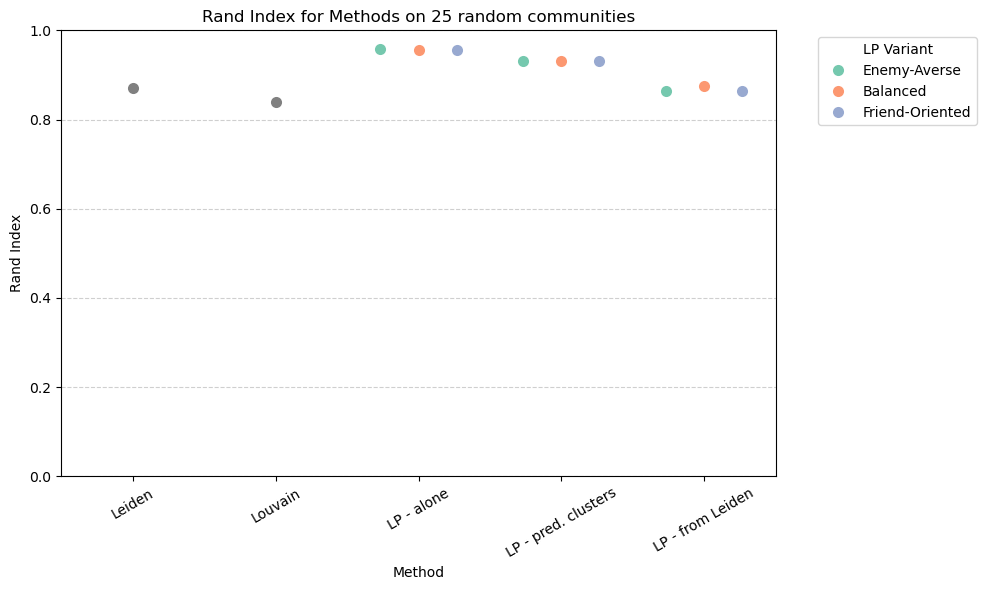

Figure saved as /Users/User/Downloads/local-popular-main-final/0203/25 random communities-Modularity.png


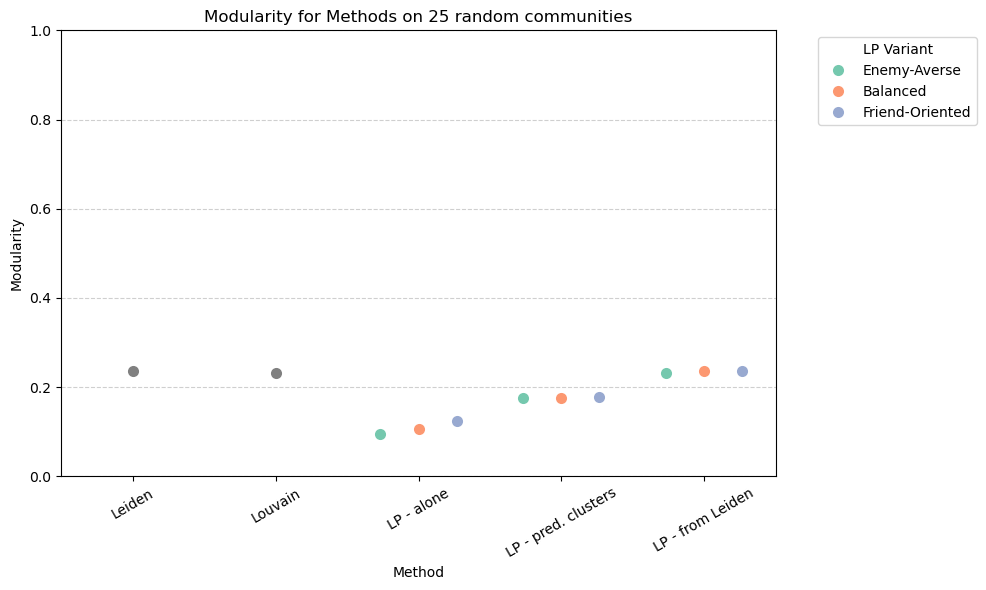

Figure saved as /Users/User/Downloads/local-popular-main-final/0203/Cora-Rand Index.png


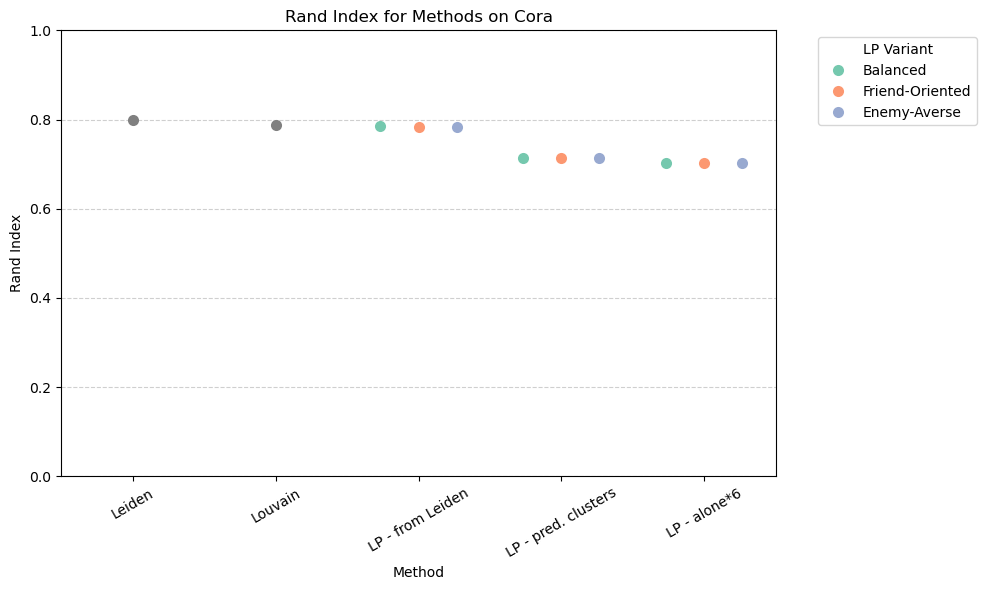

Figure saved as /Users/User/Downloads/local-popular-main-final/0203/Cora-Modularity.png


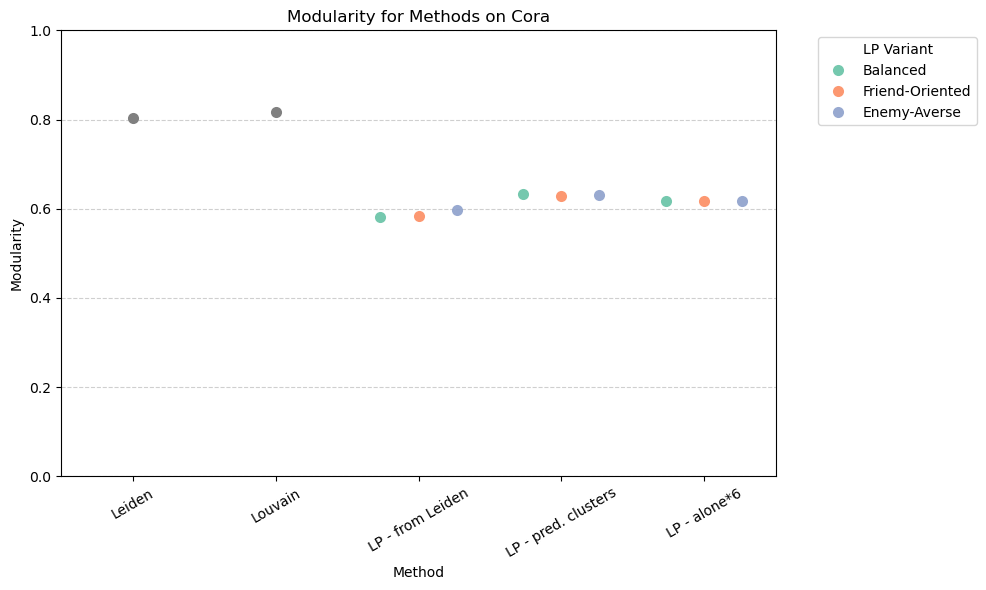

Figure saved as /Users/User/Downloads/local-popular-main-final/0203/Jazz-Rand Index.png


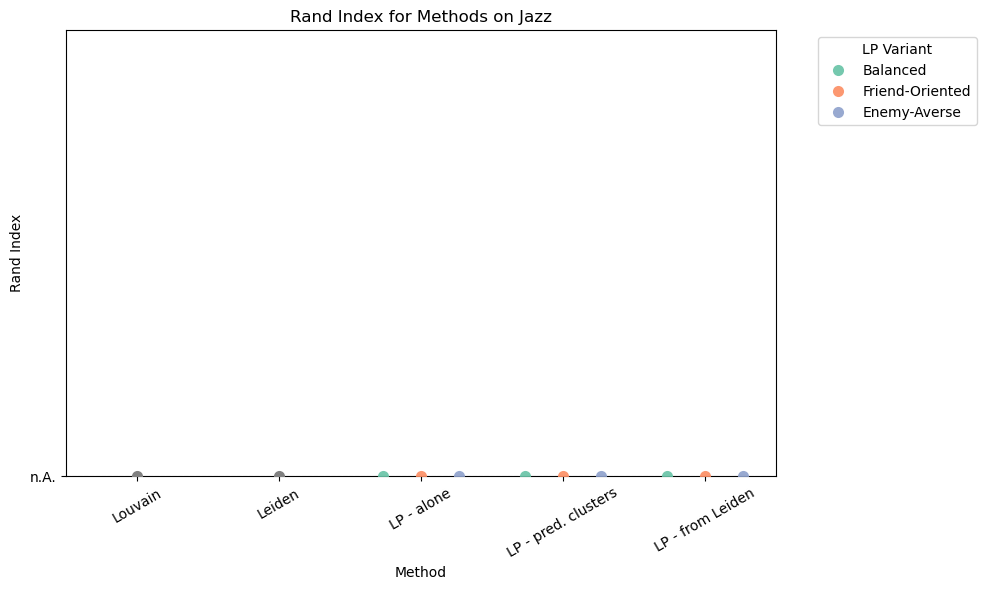

Figure saved as /Users/User/Downloads/local-popular-main-final/0203/Jazz-Modularity.png


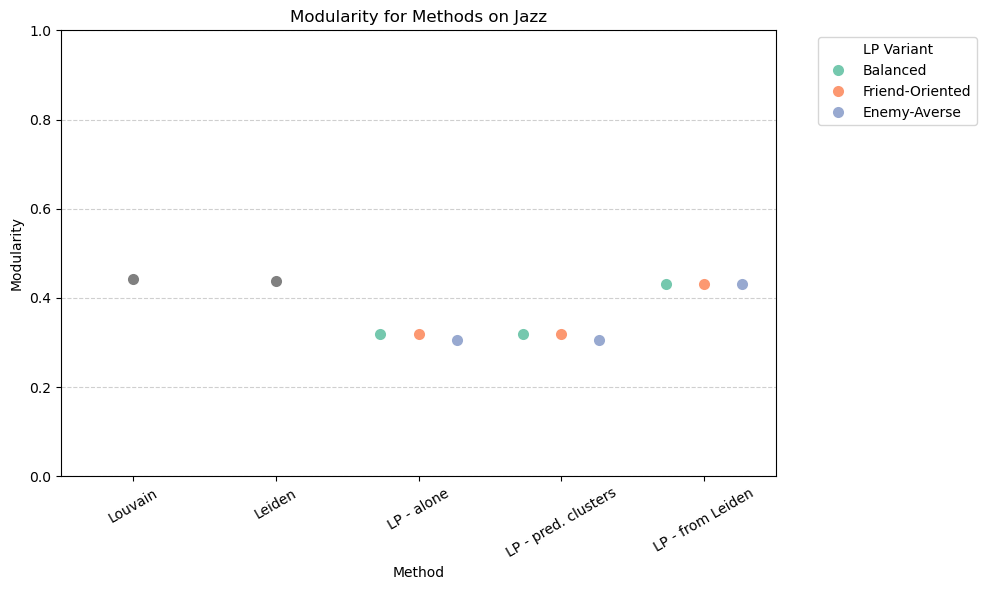

Figure saved as /Users/User/Downloads/local-popular-main-final/0203/Karate Club-Rand Index.png


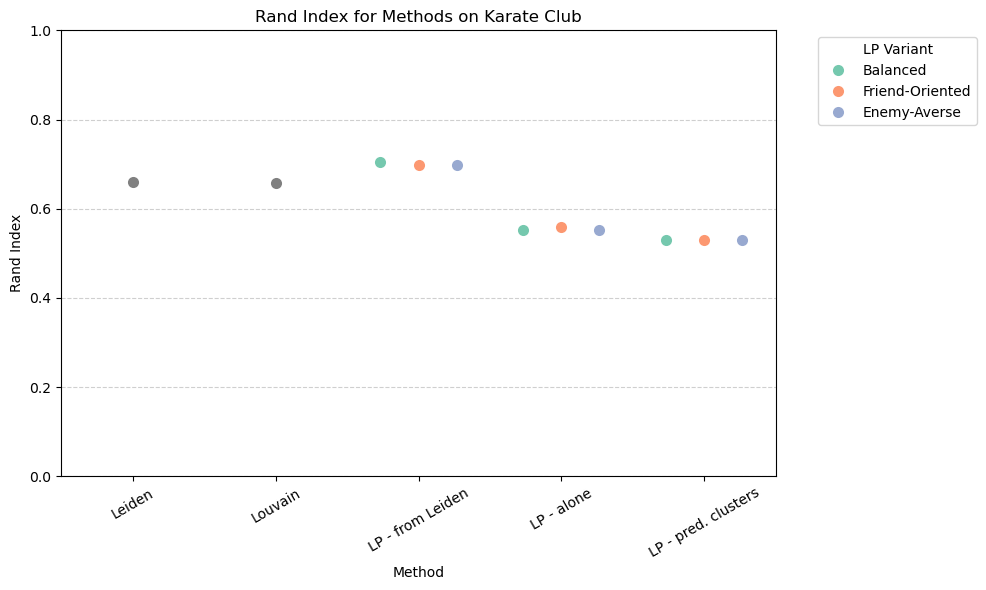

Figure saved as /Users/User/Downloads/local-popular-main-final/0203/Karate Club-Modularity.png


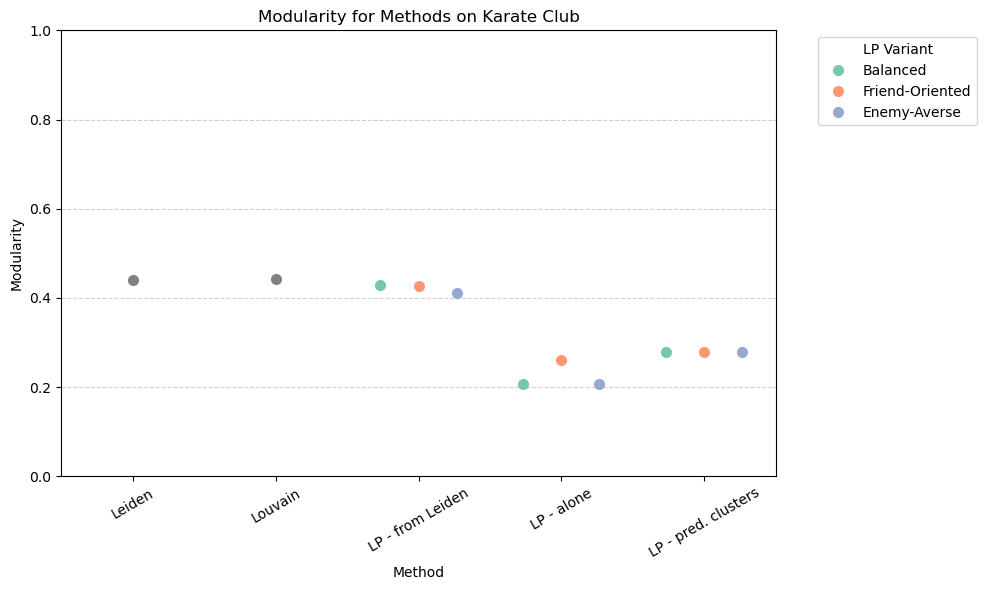

In [90]:
for Dataset in ['25 random communities', 'Cora' ,'Jazz' ,'Karate Club']:
    for score in ['Rand Index', 'Modularity']:
        plot_score_by_method(sorted_df, Dataset, score_col = score, save_path=f'/Users/User/Downloads/local-popular-main-final/0203/{Dataset}-{score}.png')


In [91]:
import itertools
import timeit

f = 0.4   #f-bound
e = 0.4   #e-bound


graphs = [karate_perm_graph,cora_perm_graph,jazz_perm_graph,graph_perm_graph]
expected_clusters = [2,7,None,25]
graph_names = [ 'Karate Club','Cora','Jazz','25 random communities']
graph_truths =  [karate_perm_truth,cora_perm_truth,jazz_perm_truth,graph_perm_truth]


𝓗 = Modularity(1.0)

fn_louvain_mod = lambda G,_: louvain(G, 𝓗)
fn_leiden_mod  = lambda G,_: leiden(G, 𝓗)

louv_out = None
lei_out = None

algorithms = [ fn_louvain_mod, fn_leiden_mod]
algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)']

lp_a_b =lambda agents, initial_clustering, pre: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='B',pre = pre)
lp_a_f =lambda agents, initial_clustering, pre: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='F',pre = pre)
lp_a_e =lambda agents, initial_clustering, pre: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='E',pre = pre)

algorithms = [ fn_louvain_mod, fn_leiden_mod,lp_a_b,lp_a_f,lp_a_e]
algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)','LP (Balanced) Heuristic',\
               'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
is_lp_heuristic = [False,False,True, True, True]

collected_data = {}
for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
    itertools.product(zip(graphs, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
    
        
        
    agents = []
    for i in range(len(graph)):
        agents += [list(graph[i].nodes())]


    if lp_heuristic:
        # start with everyone alone
        a_name_modified = a_name + ' starting with everyone alone'
        initial_clusters = len(agents[0])
        if graph == cora_perm_graph:
            a_name_modified += ' *6 starting clusters'
            initial_clusters = 6
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        
        test_callable = lambda a: algo(a,initial_clusters,None)
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        
        # starting with predicted number of clusters
        a_name_modified = a_name + ' starting with predicted number of clusters'
        initial_clusters = clusters
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        
        test_callable = lambda a: algo(a,initial_clusters,None)
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        
        # start with the output of leiden
        a_name_modified = a_name + ' starting with the output of leiden'
        initial_clusters = clusters
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        
        test_callable = lambda a: algo(a,initial_clusters,fn_leiden_mod)
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)

        rand_score_with_init = sum(rand_score(list(out.values()), list(lei.values())) for out, lei in zip(outputs, lei_output)) / len(outputs)
        scores['Rand Score with initial clustering'] = rand_score_with_init
        
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

       

    else:
        print(f"Running {a_name} on {g_name} … ", end='')
        test_callable = lambda a : algo(a,_)
        times,outputs = time_tester(test_callable,graph)
        outputs = [extract_labels_from_communities(c.communities) for c in outputs]

        if algo == fn_leiden_mod:
            lei_output = outputs
            
        
        avg_time = sum(times)/len(times)
        scores = calculate_scores_CD(outputs,truth,graph)
        scores['Time'] = avg_time
        collected_data[(a_name,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))


Running Louvain (Mod) on Karate Club … execution time: ~ 0.010190 seconds.
Rand Index : ~ 0.6570409982174688
Modularity : ~ 0.44259477895841537
Time : ~ 0.010189880001416896
Running Leiden (Mod) on Karate Club … execution time: ~ 0.022526 seconds.
Rand Index : ~ 0.6577540106951872
Modularity : ~ 0.44490358126721763
Time : ~ 0.022525980000500566
Running LP (Balanced) Heuristic starting with everyone alone on Karate Club … execution time: ~ 0.011795 seconds.
Rand Index : ~ 0.8645276292335116
Modularity : ~ 0.30092202170124244
Time : ~ 0.011795360001269729
Running LP (Balanced) Heuristic starting with predicted number of clusters on Karate Club … execution time: ~ 0.002315 seconds.
Rand Index : ~ 1.0
Modularity : ~ 0.39143756676224206
Time : ~ 0.0023150600012741052
Running LP (Balanced) Heuristic starting with the output of leiden on Karate Club … execution time: ~ 0.025211 seconds.
Rand Index : ~ 0.8645276292335116
Modularity : ~ 0.30092202170124244
Rand Score with initial clustering : ~

Figure saved as /Users/User/Downloads/local-popular-main-final/0404/25 random communities-Rand Index.png


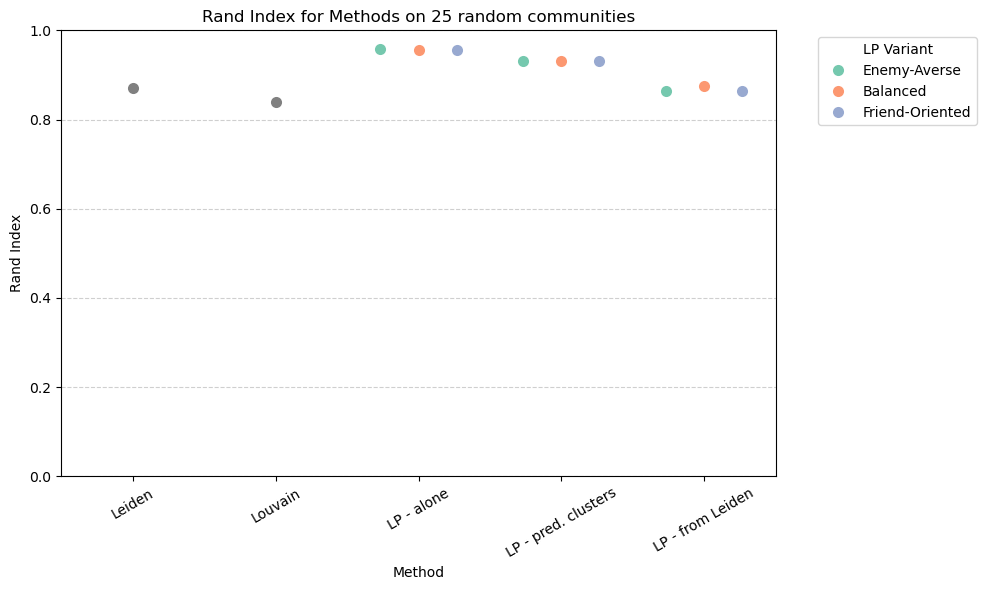

Figure saved as /Users/User/Downloads/local-popular-main-final/0404/25 random communities-Modularity.png


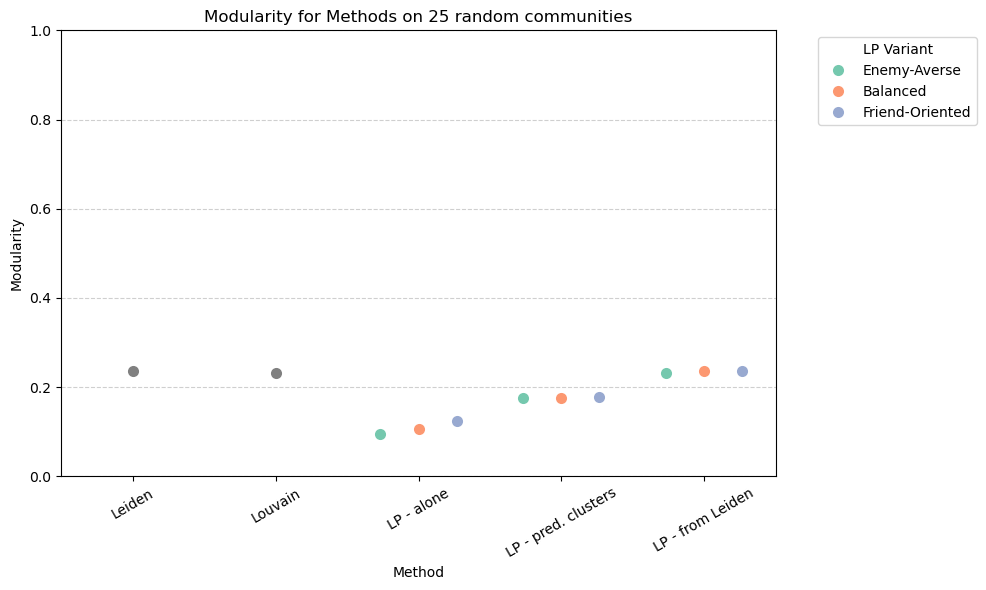

Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Cora-Rand Index.png


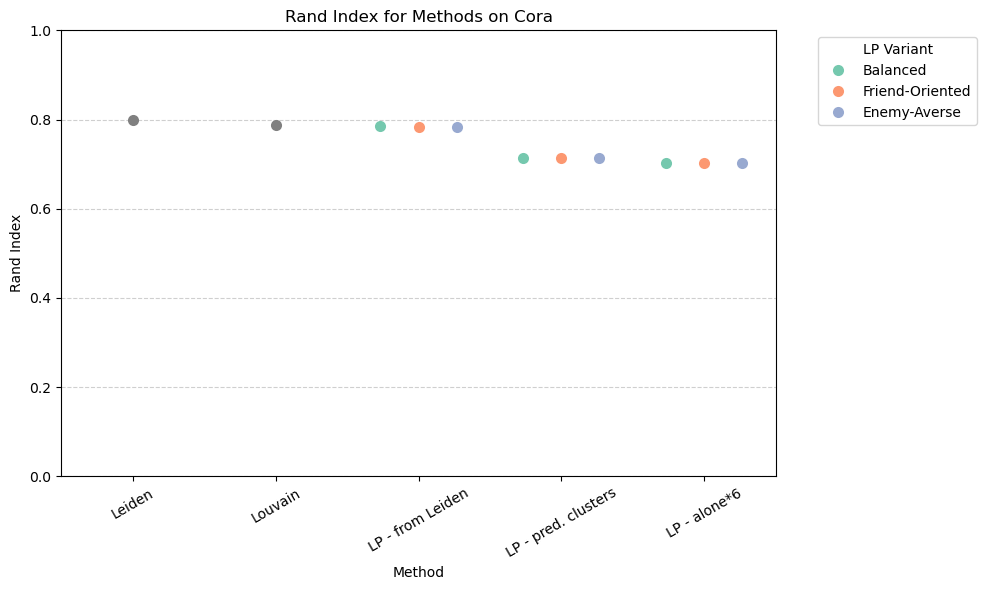

Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Cora-Modularity.png


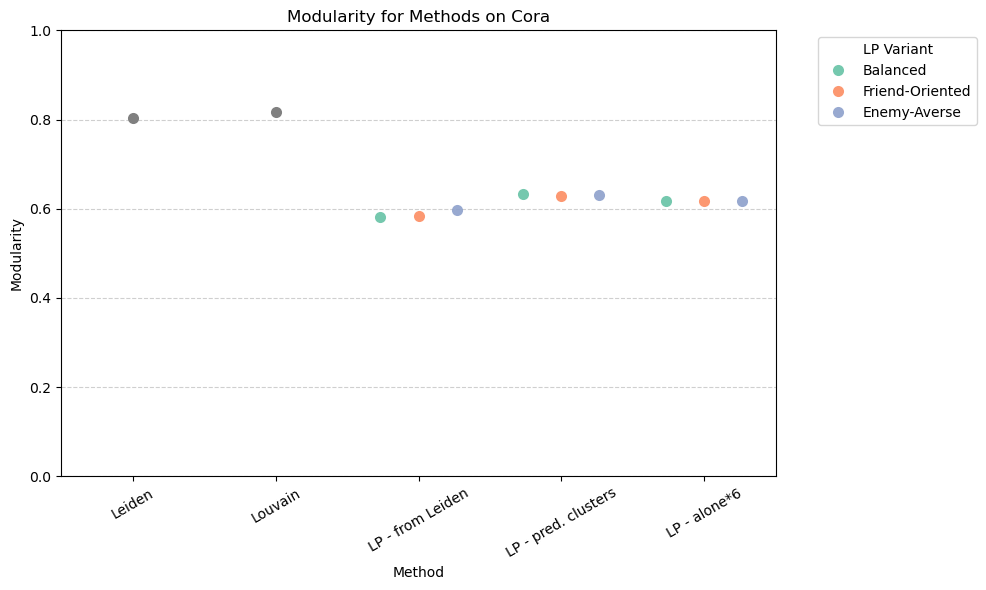

Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Jazz-Rand Index.png


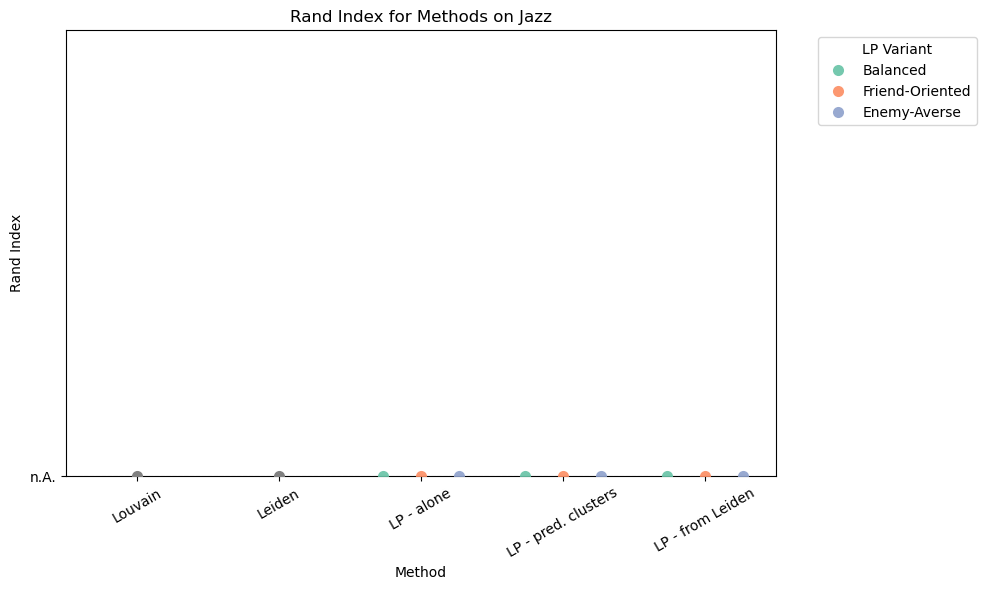

Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Jazz-Modularity.png


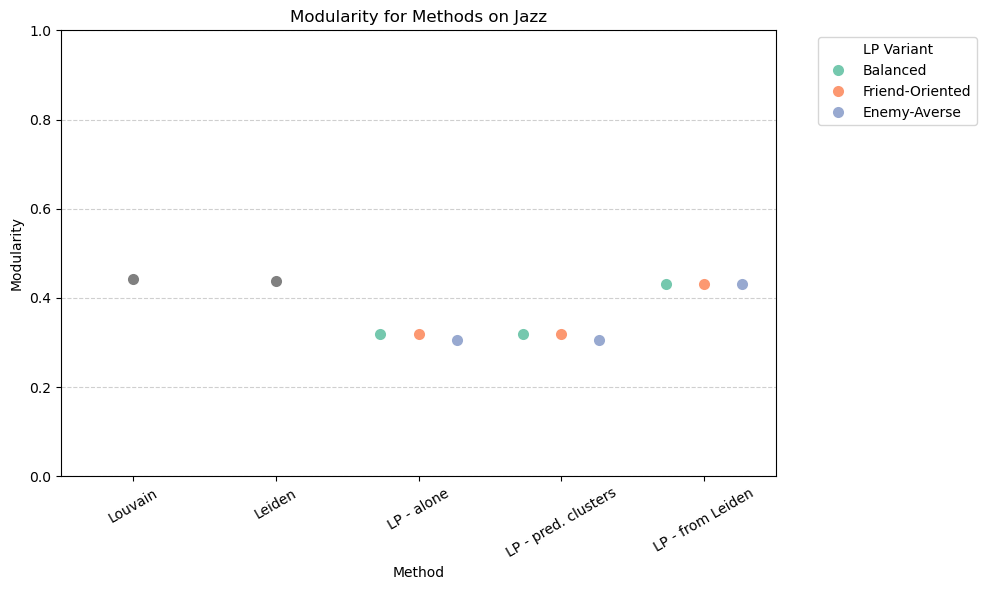

Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Karate Club-Rand Index.png


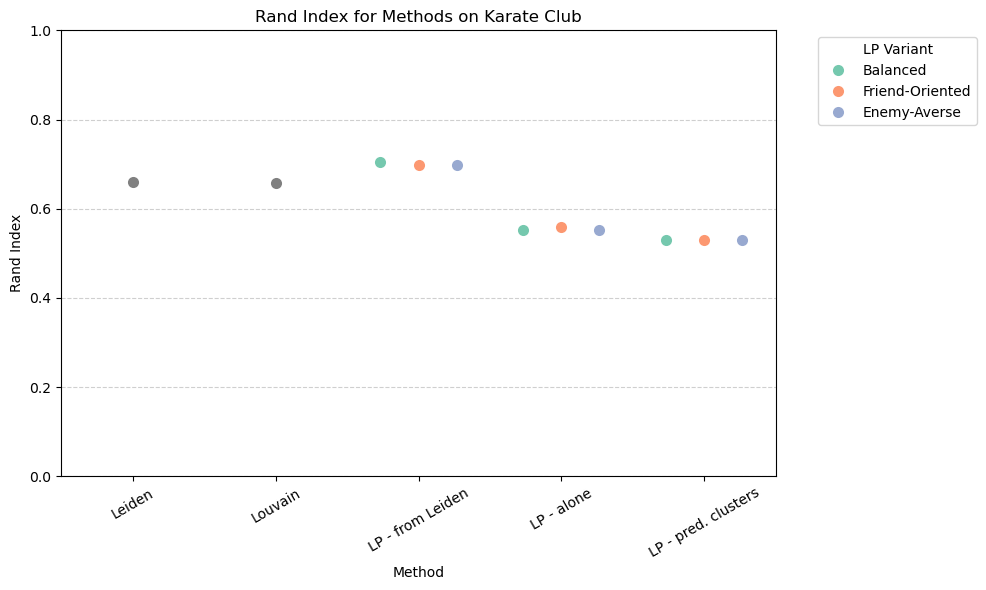

Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Karate Club-Modularity.png


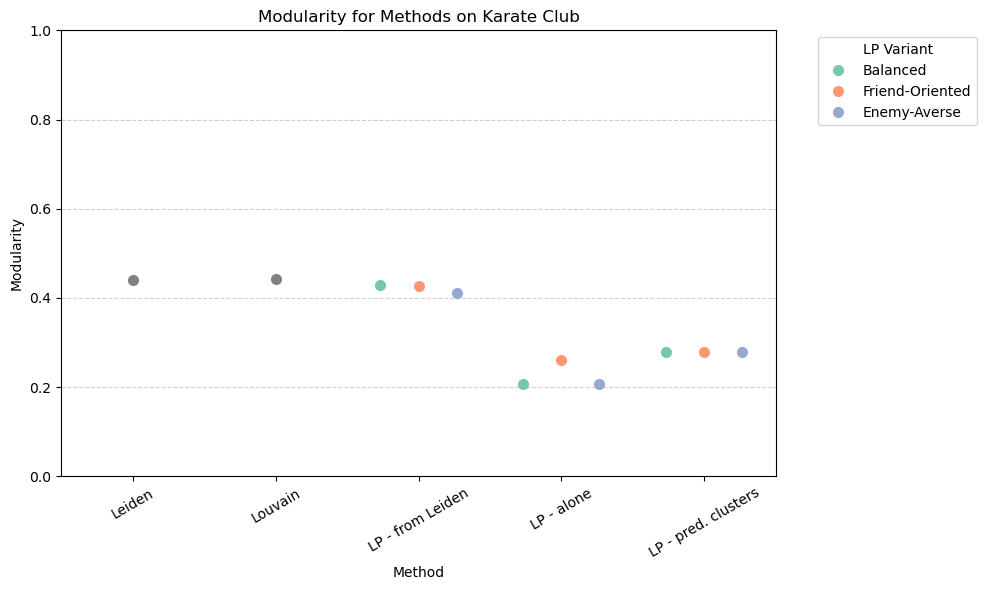

In [92]:
for Dataset in ['25 random communities', 'Cora' ,'Jazz' ,'Karate Club']:
    for score in ['Rand Index', 'Modularity']:
        plot_score_by_method(sorted_df, Dataset, score_col = score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')
